In [1399]:
import numpy as np
import pandas as pd
import glob

import scipy
import matplotlib.pyplot as plt

import itertools
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot
%matplotlib inline

from shapely.geometry import LineString, MultiLineString, MultiPoint, Point, Polygon, box, MultiPolygon
from shapely.ops import nearest_points, linemerge, unary_union, polygonize
from shapely import affinity

import geopandas as gpd
import pandas
import fiona
import json


from bokeh.io import show, output_notebook
from bokeh.models import (CDSView, ColorBar, LogColorMapper, 
                          ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.palettes import Accent as palette
palette = palette[8]
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

I'm going to put in some effort to generate Proteomaps (voronoi treemaps). Sadly, these maps are not at all trivial to make. Specifically, it isn't obvious how to generate a Voronoi diagram where the size of each cell is proportional to some specified area. With that said, there do appear to be some tools in python (using QHull?) in Scipy that are able to do some of the required calculations to generate a Voronoi diagram. In addition, a paper from. Nocaj and Brandes 2012 suggests a way forward using an iterative approach. I came across this in a recent eLife paper where they generate Proteomaps based on this approach (https://elifesciences.org/articles/36842). Sadly, they do not provide any code. While I could ask them to share, it is unclear whether it will work with our python pipeline (which I think is important overall to our effort). 

Nocaj, A., & Brandes, U. (2012). Computing Voronoi Treemaps: Faster, Simpler, and Resolution‐independent. Computer Graphics Forum, 31(3pt1), 855–864. http://doi.org/10.1111/j.1467-8659.2012.03078.x

TO DOs:
In order to use the proposed algorithm, I need to be able to generate so-called power-weighted Voronoi diagram (also known as Laguerre-Voronoi diagram), which isn't what the Scipy tool does. I have found some code snippets at https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627 that provide some help and might enable me to make progress.

Using the algorithm from Nocaj, A., & Brandes, U. (2012), I need to generate power diagram, convert 
this into polygons, and iterate to get desired cell areas. 
1. Convert the cells into polygons (try using Shapely tool which will make calculating areas and centroids quite simple). Here I also need to intercect with our bounded polygon (i.e. the bounds of the figure)
2. Perform the adaptive weighting to recorrect positions of points, etc
3. iterate as needed - comparing desired volumes to current cell volumes. 

## Code to Calculate Delaunay Triangulation and Lower Convex Hull

In [1117]:
# largely taken from; though with some modification.
# https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627#file-laguerre-voronoi-2d-py
    
def norm2(X):
    return numpy.sqrt(numpy.sum(X ** 2))

def normalized(X):
    return X / norm2(X)


def get_power_triangulation(S, R):
    # Compute the lifted weighted points -NB: THIS IS THE IMPORTANT PART for the weighting
    S_norm = np.sum(S ** 2, axis = 1) - np.array(R)# ** 2

    S_lifted = np.concatenate([S, S_norm[:,None]], axis = 1)

#     # Special case for 3 points
#     if S.shape[0] == 3:
#         if is_ccw_triangle(S[0], S[1], S[2]):
#             return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
#         else:
#             return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

    # Compute the convex hull of the lifted weighted points
    hull = ConvexHull(S_lifted)

    # Extract the Delaunay triangulation from the lower hull
    tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
    tri_list_ = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] >= 0)

#     # Compute the Voronoi points
#     V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])
#     V_ = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list_])

    return tri_list, tri_list_#, V, V_


# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
    return normalized(np.cross(A, B) + np.cross(B, C) + np.cross(C, A))


def get_power_circumcenter(A, B, C):
    N = get_triangle_normal(A, B, C)
    return (-.5 / N[2]) * N[:2]

def is_ccw_triangle(A, B, C):
    M = numpy.concatenate([np.stack([A, B, C]), np.ones((3, 1))], axis = 1)
    return numpy.linalg.det(M) > 0


# --- Compute Voronoi cells ---------------------------------------------------


def get_voronoi_cells(S, W, tri_list):
    
    '''
    Compute the segments and half-lines that delimits each Voronoi cell
      * The segments are oriented so that they are in CCW order
      * Each cell is a list of (i, j), (A, U, tmin, tmax) where
         * i, j are the indices of two ends of the segment. Segments end points are
           the circumcenters. If i or j is set to None, then it's an infinite end
         * A is the origin of the segment
         * U is the direction of the segment, as a unit vector
         * tmin is the parameter for the left end of the segment. Can be None, for minus infinity
         * tmax is the parameter for the right end of the segment. Can be None, for infinity
         * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
    '''
    S_norm = numpy.sum(S ** 2, axis = 1) - np.array(W)
    S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)
    # Compute the Voronoi points
    V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])
    # Keep track of which circles are included in the triangulation
    vertices_set = frozenset(itertools.chain(*tri_list))

    # Keep track of which edge separate which triangles
    edge_map = { }
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]

    # For each triangle
    voronoi_cell_map = { i : [] for i in vertices_set }

    for i, (a, b, c) in enumerate(tri_list):
        # For each edge of the triangle
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
        # Finite Voronoi edge
            edge = tuple(sorted((u, v)))
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j
                
                # Compute the segment parameters
                U = V[k] - V[j]
                U_norm = norm2(U)

                # Add the segment
                voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
            else: 
            # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = S[u], S[v], S[w], V[i]
                U = normalized(B - A)
                I = A + numpy.dot(D - A, U) * U
                W = normalized(I - D)
                if numpy.dot(W, I - C) < 0:
                    W = -W
                    
                # Add the segment
                voronoi_cell_map[u].append(((edge_map[edge][0], np.inf), (D,  W, 0, np.inf)))
                voronoi_cell_map[v].append(((np.inf, edge_map[edge][0]), (D, -W, np.inf, 0)))



    # Order the segments
    def order_segment_list(segment_list):
        # Pick the first element
        first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

        # In-place ordering
        segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
        for i in range(len(segment_list) - 1):
            for j in range(i + 1, len(segment_list)):
                if segment_list[i][0][1] == segment_list[j][0][0]:
                    segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                    break

        return segment_list

    return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }




## Code to Run Algorithm of Nocaj & Brande 2012.

In [1400]:
def compute_power_voronoi_map(S, W, border, eps):
    '''
    input: 
    S - Voronoi points/sites
    W - positive real weights associated with Voronoi points
    eps - for shapely conversion of lines to polygon - needed?
    border - bounds of desired map
    
    output:
    tri_list: Delaunay triangulation from the lower hull
    V_cell: Set of polygons forming all Voronoi cells
    
    '''
    # Compute the power triangulation of the circles
    if S.shape[0] > 3:
        tri_list, tri_list_ = get_power_triangulation(S, W)
    

        # Compute the Voronoi cells
        voronoi_cell_map = get_voronoi_cells(S, W, tri_list)
    #         voronoi_cell_map_ = get_voronoi_cells(S, tri_list_)


        # get the lines associated with all the Voronoi cells
        edge_map = { }
        for segment_list in voronoi_cell_map.values():
            for edge, (A, U, tmin, tmax) in segment_list:
                edge = tuple(sorted(edge))
                if edge not in edge_map:
                    if tmax is np.inf:
                        tmax = 20
                    if tmin is np.inf:
                        tmin = -20

                    edge_map[edge] = (A + tmin * U, A + tmax * U)

        V_map = MultiLineString(list(edge_map.values())).buffer(eps)

        V_cell = border.difference(V_map)

        while len(S) != len(V_cell):
            V_cell = VoronoiMap_fix(S, V_cell)
            
            
    elif S.shape[0] <= 3:
        S_points = MultiPoint(S[:2]) 
        bisect = affinity.rotate(LineString(S_points), 90, 'center')
        bisect = affinity.scale(bisect, xfact=100, yfact=100)

        borders = unary_union(linemerge([border.boundary, bisect]))
        V_cell = MultiPolygon(polygonize(borders))
        
        while len(S) != len(V_cell):
            V_cell = VoronoiMap_fix(S, V_cell)
                
#     elif S.shape[0] == 2:
#         S_points = MultiPoint(S) 
#         bisect = affinity.rotate(LineString(S_points), 90, 'center')
#         bisect = affinity.scale(bisect, xfact=100, yfact=100)
        
#         borders = unary_union(linemerge([border.boundary, bisect]))
#         V_cell = MultiPolygon(polygonize(borders))
    
    return V_cell


def VoronoiMap_fix(S, V_cell):
    '''
    Use to shift Voronoi sites and adapt weights W 
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    S: Voronoi points
    
    output:
    V_cell_corr - Corrected Voronoi polygons
    '''

    S_points = MultiPoint(S)

    V_cell_ = MultiPolygon([cell for cell in V_cell if ((cell.intersection(S_points)).type  != 'MultiPoint')])
    V_ = MultiPolygon([cell for cell in V_cell if ((cell.intersection(S_points)).type  == 'MultiPoint')])

    while len(V_) >=1:
        for cell in V_:
            V_ = MultiPolygon([P for P in V_ if P != cell])
            # identify the multipe voronoi points in cell
            P = cell.intersection(S_points)
            P_coords = [((p_.xy[0][0], p_.xy[1][0])) for p_ in P]
            for s in P:
                # find point closest to s and split cell using line orthogonal to 
                # their center line
                s_coords = ((s.xy[0][0], s.xy[1][0]))
                s_other = [tuple(s_) for s_ in P_coords if tuple(s_) != tuple(s_coords)]
                NN = nearest_points((s),MultiPoint(s_other))
                bisect = affinity.rotate(LineString(NN), 90, 'center')
                bisect = affinity.scale(bisect, xfact=100, yfact=100)

                borders = unary_union(linemerge([cell.boundary, bisect]))
                cell_split = polygonize(borders)

                for cell_ in cell_split:
                    if ((cell_.intersection(S_points)).type  == 'MultiPoint'):
                        poly=[]
                        for pol in V_:
                            poly.append(pol)
                        poly.append(cell_)
                        V_ = MultiPolygon(poly)
                    else:
                        poly=[]
                        for pol in V_cell_:
                            poly.append(pol)
                        poly.append(cell_)
                        V_cell_ = MultiPolygon(poly)
                break
    return V_cell_


def AdaptPositionsWeights(S, V_cell, W):
    '''
    Use to shift Voronoi sites and adapt weights W 
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    W - positive real weights associated with Voronoi points
    
    output:
    S_new: updated Voronoi points
    W_new: updates weights
    '''
    
    S_ = []
    dist_border = []
    for s in S:
        # identify Voronoi cell associated with s
        for cell_ in V_cell:
            if (Point(s).within(cell_)):
                cell =  cell_ 
        # Move s to centroid of cell
        for pp in cell.centroid.coords: 
            S_.append(pp) 
#             break
        dist_border.append(abs(cell.exterior.distance(Point(pp))))
               
    S_new = np.array(list(map(list, S_)))
    W_new = [np.min([np.sqrt(W[i]),dist_border[i]])**2 for i in np.arange(len(W))]
    
    return S_new, W_new 



def AdaptWeights(V_cell, S, bound, W, w_desired, err = 0.001):
    '''
    Use to adapt weights W
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    S - Voronoi points
    W - positive real weights associated with Voronoi points
    w_desired - desired weighting of each cell
    err - error threshold for values in W; need to understand better.
    
    output:
    W_new: updates weights
    '''
    W_new = []
    
    for i, s in enumerate(S):
        s_other = [tuple(s_) for s_ in S if tuple(s_) != tuple(s)]
        NN = nearest_points(Point(s),MultiPoint(s_other))
        
        for cell_ in V_cell:
            if (Point(s).within(cell_)):
                cell = cell_

        
        A_current = cell.area
        A_desired = bound.area * w_desired[i]
        
        f_adapt = A_desired / A_current
         
        w_new_ = np.sqrt(W[i]) * f_adapt  
#         w_new_ = W[i] * f_adapt  
        w_max = abs(LineString(NN).length)

        W_ = np.min([w_new_, w_max])**2
#         W_new.append(W_)
        W_new.append(np.max([W_, err]))
        
    return W_new

def map_iterator(weights, border):
    # number of cells
    sample_count = len(weights)

    # initialize random Voronoi sites and weightings
    # S contains circles center, R = sqrt(W) contains 
    # circles radius for weighting the Voronoi cells
    S_ = random_points_within(border, sample_count)
    S = np.array([([s.x, s.y]) for s in S_])

    W = .8 * numpy.random.random(sample_count) + .2

    # generate initial Voronoi cells
    V_cell = compute_power_voronoi_map(S, W, border, eps = 1E-6)

    # Perform iteration on initialized V_cell
    error_diff = np.inf
    while 0 > error_diff >= 0.00001:

        S, W = AdaptPositionsWeights(S, V_cell, W)

        V_cell = compute_power_voronoi_map(S, W, border, eps = 1E-6)

        W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)

        V_cell = compute_power_voronoi_map(S, W, border, eps = 1E-6)

        # calculate discrepency between desired cell area and
        # current cell area.
        A_diff = 0
        for i,  s in enumerate(S):
            # identify Voronoi cell associated with s
            for cell_ in V_cell:
                if (Point(s).within(V_cell)):
                    cell =  cell_ 
            A_diff += abs(cell.area - border.area * weights[i])

        error_diff = error_calc -  A_diff/(2*border.area)
        error_calc =  A_diff/(2*border.area)    
    
    return V_cell


def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []

    while len(points) < num_points:
        random_point = Point([np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)

    return points


# # selection of random initialization points
# def disc_uniform_pick(N):
#     angle = (2 * numpy.pi) * numpy.random.random(N)
#     out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
#     out *= numpy.sqrt(numpy.random.random(N))[:,None]
#     return out

## Treemap structure - testing on single level

Okay, progress! It looks like the algorithm is roughly working from some initial testing; though it is a little buggy and hangs/errors sometimes. It'll still need some work. 

In any case, lets next try to build a treemap structure that takes in the different proteome sector categories and determines the weightings based on protein abundance. This will be a multi-level structure: we will begin with our main plot bounds (i.e. square box) and generate cells with the higher-level categories; Each cell will then become a new set of bounds to build another set of cells that will house lower-level categories (or individual proteins). I suspect we will want to build seperate diagrams for each lower-level category (where will be the place to show individual genes).

Lets begin with the 'cog_class' categories.

In [785]:
# Load the dataset with aboslute measurements
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')
data = data[data.condition == 'lb_miller']
cog_dict = dict(zip(data.cog_class.unique(), np.arange(len(data.cog_class.unique()))))

In [783]:
data.head()

,gene_name,b_number,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
0,InsH-1,b0259,lb_miller,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.90,CP4-6 prophage; IS5 transposase and trans-acti...,176.675627,0.011534,schmidt_2016,Schmidt et al. 2016,BW25113
1,InsH-1,b0259,glycerol_pAA,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.27,CP4-6 prophage; IS5 transposase and trans-acti...,101.424400,0.006621,schmidt_2016,Schmidt et al. 2016,BW25113
2,InsH-1,b0259,acetate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.30,CP4-6 prophage; IS5 transposase and trans-acti...,21.374427,0.001395,schmidt_2016,Schmidt et al. 2016,BW25113
3,InsH-1,b0259,fumarate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.42,CP4-6 prophage; IS5 transposase and trans-acti...,64.846091,0.004233,schmidt_2016,Schmidt et al. 2016,BW25113
4,InsH-1,b0259,galactose,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.26,CP4-6 prophage; IS5 transposase and trans-acti...,46.647597,0.003045,schmidt_2016,Schmidt et al. 2016,BW25113


In [786]:
# compute fractional abundance

frac = pd.DataFrame()
# generate desired area weightings
for cog, d in data.groupby('cog_class'):
    frac_ = d.fg_per_cell.sum()/ data.fg_per_cell.sum()
    frac = frac.append({'mass_frac':frac_,
                       'cog_class': cog,
                       'cog_dict' : cog_dict[d.cog_class.unique()[0]]}, ignore_index=True )

In [652]:
# initialize random Voronoi sites and weightings
# S contains circles center, R contains circles radius for weighting the Voronoi cells
# sample_count = 5 #len(frac)
sample_count = len(frac)
S = 5 * disc_uniform_pick(sample_count)
W = .8 * numpy.random.random(sample_count) + .2

## initialize Laguerre-Voronoi diagram
tri_list,  tri_list_, V, V_ = get_power_triangulation(S, W)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

eps = 0.0000001
# eps = 1E-6
# weights = np.ones(sample_count)*0.2 #frac.mass_frac.values
weights = frac.mass_frac.values
# weights = np.array([0.6, 0.1, 0.1, 0.3, 0.2])

# border
b_s = 15
border = box(-b_s, -b_s, b_s, b_s)
# err_thresh = 0.1

In [653]:
tri_list, tri_list_, V_cell, V_, voronoi_cell_map_ = compute_power_voronoi_map(S, W, border)

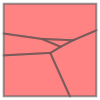

In [655]:
V_cell

In [656]:
# #look at error
# for i, cell in enumerate(V_cell):
#     print(cell.area - (border.area * weights[i]))

for i,  s in enumerate(S):
    # identify Voronoi cell associated with s
    for cell_ in V_cell:
        if (Point(s).within(cell_)):
            cell =  cell_ 
    print(cell.area/(border.area * weights[i]))

16.063561566181306
1.3747262934506175
0.04384475584721007
0.20280844615496907
16.941940142386475


In [657]:
# Perform iteration on initialized V_cell
for i in np.arange(100):
    S, W = AdaptPositionsWeights(S, V_cell, W)

    V_cell = compute_power_voronoi_map(S, W, border)

    W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)

    V_cell = compute_power_voronoi_map(S, W, border)

    # calculate discrepency between desired cell area and
    # current cell area.
    # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
    # so this needs some work
    A_diff = 0
    for i,  s in enumerate(S):
        # identify Voronoi cell associated with s
        for cell_ in V_cell:
            if (Point(s).within(cell_)):
                cell =  cell_ 
        A_diff += abs(cell.area - border.area * weights[i])
    error_calc =  A_diff/(2*border.area)
    
    print(error_calc)
    print(len(V_cell))


0.41278503432654523
5
0.340880350514974
5
0.34636373349123234
5
0.359876208031132
5
0.34880446296160833
5
0.30774014055470983
5
0.3042553551122539
5
0.31052506829052345
5
0.3110018856000922
5
0.33516308802010736
5
0.3368567709129188
5
0.3227589790034963
5
0.3139827031089116
5
0.14382439086020976
5
0.07914672315796124
5
0.09304785744445636
5
0.09674591262358945
5
0.09902380526178241
5
0.09993116515359951
5
0.10035053917960936
5
0.10141657443905813
5
0.10243047610328741
5
0.10311218764743936
5
0.1036259208069303
5
0.10402433815911441
5
0.1043418874578396
5
0.10458936317871093
5
0.10475656775480412
5
0.10481177698250119
5
0.10469262849341064
5
0.10428607210010776
5
0.10339821218674074
5
0.10172839811172049
5
0.09890247971649267
5
0.09468085982345252
5
0.09118071563901842
5
0.0891153093319454
5
0.08794925584348064
5
0.08735128869362709
5
0.08705516324646058
5
0.0869028779707902
5
0.08682161292231039
5
0.08677655277493564
5
0.08675051093786844
5
0.086734796563202
5
0.08672490654477266
5
0.0

In [658]:
for i,  s in enumerate(S):
    # identify Voronoi cell associated with s
    for cell_ in V_cell:
        if (Point(s).within(cell_)):
            cell =  cell_ 
    print(cell.area -  (border.area * weights[i]), cell.area, (border.area * weights[i]))

1.6659961469776068 17.271386023879565 15.605389876901958
-26.622832943590055 136.21307622919244 162.8359091727825
-38.59199185483948 226.17020032707376 264.76219218191324
-12.818091303333347 424.78886672684973 437.6069580301831
76.36690721253674 95.55645795075606 19.189550738219303


In [659]:
for i,  s in enumerate(S):
    # identify Voronoi cell associated with s
    for cell_ in V_cell:
        if (Point(s).within(cell_)):
            cell =  cell_ 
    print(cell.area / (border.area * weights[i]))

1.1067577394809918
0.8365051475510785
0.8542390379200229
0.9707086666056868
4.979608916035688


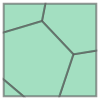

In [660]:
V_cell

In [492]:
# lets plot this!

gdf = pandas.concat([
    geopandas.GeoSeries(cell)
    for cell in V_cell
]).pipe(geopandas.GeoDataFrame)

gdf = gdf.rename(columns = {0:'geometry'})
gdf['cell'] = np.arange(5)
frac['cell'] = np.arange(5)

In [493]:
result = gdf.merge(frac, on=['cell'])

In [494]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = result.to_json())

In [496]:
# Create figure object.
p = figure(title = 'Proteomap', 
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
cells = p.patches('xs','ys', source = geosource,
                   line_color = 'black', 
                   line_width = 0.5, 
                   fill_alpha = 0.7,
                   fill_color={'field': color_column,
            'transform': LogColorMapper(palette=palette)} )
# Create hover tool
p.add_tools(HoverTool(renderers = [cells],
                      tooltips = [('Cell','@cell'),
                                 ('COG Category', '@cog_class')]))
show(p)

## Implementing Entire Proteomap Structure

It looks like things are working (mostly). Some errors still come up that need to be dealth with; and I think I still need to look into how to better obtain the lower Convex Hull.

Now lets try to implement the entire treemap. For now I'd like to have a tree structure of COG class -> COG category -> protein; with cell size dictated by total mass of the category. Note that it will likely make sense to ignore proteins that are below some threshold fraction (since it will not be possible to view these in the map.  

In addiiton, it will be nice to build seperate maps for the sub-categories since it'll be difficult to actually see most individual proteins. 

Steps:
1. Build higher level voronoi map for COG class
2. Within each cell, build maps for COG category
3. Within each of these cells, build maps for protein abundance

In [1324]:
tree_structure = ['cog_class', 'cog_category', 'gene_name']

In [1365]:
# Load the dataset with aboslute measurements
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')

# consider only M9 glucose, schmidt 
data = data[data.dataset == 'schmidt_2016']
data = data[data.condition == 'glucose']
cog_dict = dict(zip(data.cog_class.unique(), np.arange(len(data.cog_class.unique()))))

In [1394]:
proteomap_df = pd.DataFrame()

for tree_i, tree in enumerate(tree_structure):
    
    if tree_i == 0:        
        # border
        b_s = 15
        border = box(-b_s, -b_s, b_s, b_s) 
        
        # compute desired cell weightings
        frac = pd.DataFrame()
        for _, d in data.groupby(tree_structure[tree_i]):
            frac_ = d.fg_per_cell.sum()/ data_tree.fg_per_cell.sum()
            frac = frac.append({'mass_frac':frac_,
                               'cog_class' : d.cog_class.unique()[0],
                                'cog_dict' : cog_dict[d.cog_class.unique()[0]]
                               }, ignore_index=True )

        # set index for each cell
        frac['index'] = np.arange(len(frac))

        # desired cell weighting
        weights = frac.mass_frac.values

        V_cell = map_iterator(weights, border)

        # save cells to DataFrame
        gdf = pandas.concat([
        geopandas.GeoSeries(cell)
            for cell in V_cell
        ]).pipe(geopandas.GeoDataFrame)

        gdf = gdf.rename(columns = {0:'geometry'})
        gdf['index'] = np.arange(len(frac))
        gdf['level'] = tree_i

        proteomap_df = proteomap_df.append(gdf.merge(frac, on=['index']))
        
    else:
        for cat, cell in proteomap_df[proteomap_df['level'] == tree_i-1].groupby(tree_structure[tree_i-1]):  

            if cat == 'Not Assigned':
                continue
                
            data_tree = data[data[tree_structure[(tree_i-1)]] == cat]
            frac = pd.DataFrame()

            border = cell.geometry[cell.index[0]]

            # compute desired cell weightings
            frac = pd.DataFrame()
            for cat_, d in data_tree.groupby(tree_structure[(tree_i)]):
                print(cat, cat_)
                frac_ = d.fg_per_cell.sum()/ data_tree.fg_per_cell.sum()
                frac = frac.append({'mass_frac':frac_,
                                   'cog_category' : d.cog_category.unique()[0],
                                   'cog_class' : d.cog_class.unique()[0],
                                   'cog_dict' : cog_dict[d.cog_class.unique()[0]]
                                   }, ignore_index=True )

            # don't attemp to make cells for very low abundant items
            frac = frac[frac.mass_frac >= 0.01]

            # set index for each cell
            frac['index'] = np.arange(len(frac))

            # desired cell weighting
            weights = frac.mass_frac.values

            result = None
            while result is None:
                try:
                    V_cell = map_iterator(weights, border)

                    # save cells to DataFrame
                    gdf = pandas.concat([
                    geopandas.GeoSeries(cell)
                        for cell in V_cell
                    ]).pipe(geopandas.GeoDataFrame)

                    gdf = gdf.rename(columns = {0:'geometry'})
                    gdf['index'] = np.arange(len(frac))
                    gdf['level'] = tree_i

                    proteomap_df = proteomap_df.append(gdf.merge(frac, on=['index']))
                    result = True
                except:
                    pass


cellular processes and signaling cell cycle control, cell division, chromosome partitioning
cellular processes and signaling cell motility
cellular processes and signaling cell wall/membrane/envelope biogenesis
cellular processes and signaling defense mechanisms
cellular processes and signaling extracellular structures
cellular processes and signaling intracellular trafficking, secretion, and vesicular transport
cellular processes and signaling mobilome: prophages, transposons
cellular processes and signaling posttranslational modification, protein turnover, chaperones
cellular processes and signaling signal transduction mechanisms
information storage and processing RNA processing and modification
information storage and processing Replication, recombination, and repair
information storage and processing transcription
information storage and processing translation, ribosomal structure and biogenesis
metabolism amino acid transport and metabolism
metabolism carbohydrate transport and me

amino acid transport and metabolism leuC
amino acid transport and metabolism leuD
amino acid transport and metabolism livF
amino acid transport and metabolism livG
amino acid transport and metabolism livJ
amino acid transport and metabolism livK
amino acid transport and metabolism livM
amino acid transport and metabolism ltaE
amino acid transport and metabolism lysA
amino acid transport and metabolism lysC
amino acid transport and metabolism metA
amino acid transport and metabolism metB
amino acid transport and metabolism metC
amino acid transport and metabolism metE
amino acid transport and metabolism metF
amino acid transport and metabolism metH
amino acid transport and metabolism metI
amino acid transport and metabolism metL
amino acid transport and metabolism metN
amino acid transport and metabolism mhpE
amino acid transport and metabolism mmuM
amino acid transport and metabolism mnaT
amino acid transport and metabolism mppA
amino acid transport and metabolism nanA
amino acid trans

carbohydrate transport and metabolism pykF
carbohydrate transport and metabolism rbsA
carbohydrate transport and metabolism rbsB
carbohydrate transport and metabolism rbsC
carbohydrate transport and metabolism rbsD
carbohydrate transport and metabolism rbsK
carbohydrate transport and metabolism rpiA
carbohydrate transport and metabolism rpiB
carbohydrate transport and metabolism srlB
carbohydrate transport and metabolism srlE
carbohydrate transport and metabolism suhB
carbohydrate transport and metabolism tabA
carbohydrate transport and metabolism talA
carbohydrate transport and metabolism talB
carbohydrate transport and metabolism tktA
carbohydrate transport and metabolism tktB
carbohydrate transport and metabolism tpiA
carbohydrate transport and metabolism treA
carbohydrate transport and metabolism treB
carbohydrate transport and metabolism treC
carbohydrate transport and metabolism ugpB
carbohydrate transport and metabolism ugpC
carbohydrate transport and metabolism uhpT
carbohydrat

cell wall/membrane/envelope biogenesis wbbK
cell wall/membrane/envelope biogenesis wecA
cell wall/membrane/envelope biogenesis wecB
cell wall/membrane/envelope biogenesis wecC
cell wall/membrane/envelope biogenesis wzc
cell wall/membrane/envelope biogenesis wzzB
cell wall/membrane/envelope biogenesis wzzE
cell wall/membrane/envelope biogenesis yafK
cell wall/membrane/envelope biogenesis ybiS
cell wall/membrane/envelope biogenesis ybjS
cell wall/membrane/envelope biogenesis ycfS
cell wall/membrane/envelope biogenesis yeaY
cell wall/membrane/envelope biogenesis yeeZ
cell wall/membrane/envelope biogenesis yejM
cell wall/membrane/envelope biogenesis yfdH
cell wall/membrane/envelope biogenesis ygeA
cell wall/membrane/envelope biogenesis ygeR
cell wall/membrane/envelope biogenesis yhjG
cell wall/membrane/envelope biogenesis yiaD
cell wall/membrane/envelope biogenesis yidC
cell wall/membrane/envelope biogenesis ynaI
cell wall/membrane/envelope biogenesis ynhG
coenzyme transport and metabolism

energy production and conversion pckA
energy production and conversion pflB
energy production and conversion pntA
energy production and conversion pntB
energy production and conversion ppc
energy production and conversion prpC
energy production and conversion prr
energy production and conversion pta
energy production and conversion puuC
energy production and conversion qorA
energy production and conversion rclA
energy production and conversion rsxC
energy production and conversion rsxG
energy production and conversion sad
energy production and conversion sdhA
energy production and conversion sdhB
energy production and conversion sdhC
energy production and conversion sdhD
energy production and conversion sthA
energy production and conversion sucA
energy production and conversion sucB
energy production and conversion sucC
energy production and conversion sucD
energy production and conversion tam
energy production and conversion ubiF
energy production and conversion ubiI
energy production

inorganic ion transport and metabolism dps
inorganic ion transport and metabolism efeO
inorganic ion transport and metabolism fecA
inorganic ion transport and metabolism feoA
inorganic ion transport and metabolism feoB
inorganic ion transport and metabolism fepA
inorganic ion transport and metabolism fepB
inorganic ion transport and metabolism fepC
inorganic ion transport and metabolism fes
inorganic ion transport and metabolism fetA
inorganic ion transport and metabolism fhuA
inorganic ion transport and metabolism fhuE
inorganic ion transport and metabolism fhuF
inorganic ion transport and metabolism fiu
inorganic ion transport and metabolism focA
inorganic ion transport and metabolism ftnA
inorganic ion transport and metabolism ftsP
inorganic ion transport and metabolism fur
inorganic ion transport and metabolism glpE
inorganic ion transport and metabolism gppA
inorganic ion transport and metabolism gsiC
inorganic ion transport and metabolism katE
inorganic ion transport and metaboli

nucleotide transport and metabolism nrdF
nucleotide transport and metabolism nudC
nucleotide transport and metabolism nudJ
nucleotide transport and metabolism nupC
nucleotide transport and metabolism psuG
nucleotide transport and metabolism purA
nucleotide transport and metabolism purB
nucleotide transport and metabolism purC
nucleotide transport and metabolism purD
nucleotide transport and metabolism purE
nucleotide transport and metabolism purF
nucleotide transport and metabolism purH
nucleotide transport and metabolism purK
nucleotide transport and metabolism purL
nucleotide transport and metabolism purM
nucleotide transport and metabolism purN
nucleotide transport and metabolism purT
nucleotide transport and metabolism purU
nucleotide transport and metabolism pyrB
nucleotide transport and metabolism pyrC
nucleotide transport and metabolism pyrD
nucleotide transport and metabolism pyrE
nucleotide transport and metabolism pyrF
nucleotide transport and metabolism pyrG
nucleotide trans

secondary metabolites biosynthesis, transport, and catabolism aas
secondary metabolites biosynthesis, transport, and catabolism acpP
secondary metabolites biosynthesis, transport, and catabolism curA
secondary metabolites biosynthesis, transport, and catabolism dkgA
secondary metabolites biosynthesis, transport, and catabolism dkgB
secondary metabolites biosynthesis, transport, and catabolism elbB
secondary metabolites biosynthesis, transport, and catabolism entA
secondary metabolites biosynthesis, transport, and catabolism entB
secondary metabolites biosynthesis, transport, and catabolism entC
secondary metabolites biosynthesis, transport, and catabolism entE
secondary metabolites biosynthesis, transport, and catabolism entF
secondary metabolites biosynthesis, transport, and catabolism entH
secondary metabolites biosynthesis, transport, and catabolism fabB
secondary metabolites biosynthesis, transport, and catabolism fabF
secondary metabolites biosynthesis, transport, and catabolism f

translation, ribosomal structure and biogenesis lasT
translation, ribosomal structure and biogenesis lepA
translation, ribosomal structure and biogenesis leuS
translation, ribosomal structure and biogenesis lysS
translation, ribosomal structure and biogenesis lysU
translation, ribosomal structure and biogenesis map
translation, ribosomal structure and biogenesis metG
translation, ribosomal structure and biogenesis miaA
translation, ribosomal structure and biogenesis miaB
translation, ribosomal structure and biogenesis mnmA
translation, ribosomal structure and biogenesis mnmC
translation, ribosomal structure and biogenesis mnmE
translation, ribosomal structure and biogenesis mnmG
translation, ribosomal structure and biogenesis mraZ
translation, ribosomal structure and biogenesis pcnB
translation, ribosomal structure and biogenesis pheS
translation, ribosomal structure and biogenesis pheT
translation, ribosomal structure and biogenesis pnp
translation, ribosomal structure and biogenesis 

translation, ribosomal structure and biogenesis ymdB
translation, ribosomal structure and biogenesis yqjD


In [1396]:
geosource_ = GeoJSONDataSource(geojson = proteomap_df.to_json())

In [1397]:
color_column = 'cog_dict'

# Create figure object.
p = figure(title = 'Proteomap', 
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

cells = p.patches('xs','ys', source = geosource_,
                   line_color = 'black', 
                   line_width = 0.5, 
                   fill_alpha = 0.2,
                   fill_color={'field': color_column,
            'transform': LogColorMapper(palette=palette)} )

# Create hover tool
p.add_tools(HoverTool(renderers = [cells],
                      tooltips = [('COG Class', '@cog_class'),
                                  ('COG Category', '@cog_category')]))
show(p)

In [1398]:
proteomap_df[proteomap_df.level==0]

,geometry,index,level,cog_class,cog_dict,mass_frac,cog_category
0,"POLYGON ((15.00000 -2.24142, 15.00000 -15.0000...",0,0,Not Assigned,3.0,0.999792,NaN
1,"POLYGON ((5.06521 15.00000, 15.00000 15.00000,...",1,0,cellular processes and signaling,0.0,11.746695,NaN
2,"POLYGON ((-15.00000 5.00833, -15.00000 15.0000...",2,0,information storage and processing,2.0,19.683270,NaN
3,"POLYGON ((-3.94851 -15.00000, -15.00000 -15.00...",3,0,metabolism,1.0,29.875597,NaN
4,"POLYGON ((6.48091 -15.00000, -3.94851 -15.0000...",4,0,poorly characterized,4.0,1.673687,NaN


## Ignore; used for troubleshooting

In [392]:
def display(S, tri_list, voronoi_cell_list):
    # Setup
    fig, ax = plot.subplots()
    plot.axis('equal')
    plot.axis('off')	

    # Plot the samples
    plot.scatter(S[:,0], S[:,1], lw = 0., c = 'k', zorder = 1)

    # Plot the Delaunay triangulation
    edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
    line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.8')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

    # get the lines associated with all the Voronoi cells
    edge_map = { }
    for segment_list in voronoi_cell_list.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is np.inf:
                    tmax = 20
                if tmin is np.inf:
                    tmin = -20

                edge_map[edge] = (A + tmin * U, A + tmax * U)

    line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

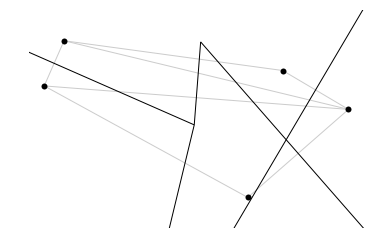

In [411]:
display(S, tri_list_, voronoi_cell_map_)

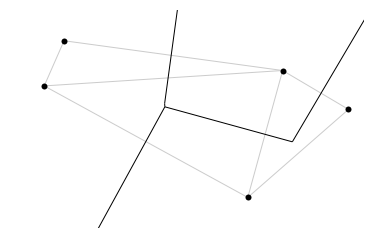

In [412]:
display(S, tri_list, voronoi_cell_map)

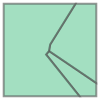

In [393]:
V_cell

In [1034]:
# Perform iteration on initialized V_cell
for i in np.arange(100):
#     print(i)
    S, W = AdaptPositionsWeights(S, V_cell, W)

    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    
    W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)
    
    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    print(len(tri_list))
    # calculate discrepency between desired cell area and
    # current cell area.
    # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
    # so this needs some work
    A_diff = 0
    for i, cell in enumerate(V_cell):
        A_diff += abs(cell.area - border.area * weights[i])
    error_calc =  A_diff/(2*border.area)

    print(error_calc)




UnboundLocalError: local variable 'cell' referenced before assignment